<a href="https://colab.research.google.com/github/KhrTim/AI-application-systems/blob/main/Weekly_sessions/week12/week_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-12-05 13:39:41--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.141, 52.216.162.85, 52.216.140.150, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  1.72MB/s    in 14s     

2022-12-05 13:39:56 (932 KB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### Inspecting the data of the Jena weather dataset

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### Parsing the data

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

### Plotting the temperature timeseries

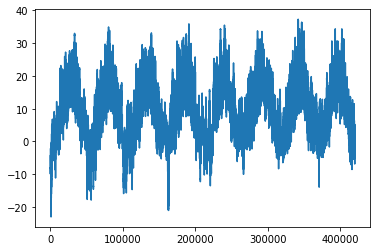

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

### Plotting the first 10 days of the temperature timeseries

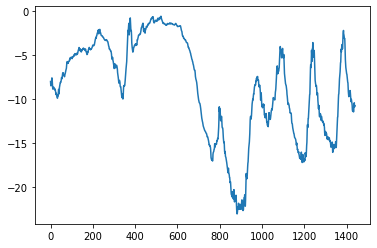

In [6]:
plt.plot(range(1440), temperature[:1440])

### Computing the number of samples we'll use for each data split

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# Preparing the data

### Normalizing the data

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
)

for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


### Installing datasets for training, validation, and testing

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples+num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

### Inspecting the output of one of our datasets

In [11]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


# A common-sense, non-machine-learning baseline

### Computing the common-sense baseline MAE

In [12]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:,-1,1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds-targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


# Let's try a basic machine-learning model !

### Training and evaluating a densley connected model

In [13]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 55ms/step - loss: 16.4290 - mae: 3.1230 - val_loss: 14.7513 - val_mae: 3.0290
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 10.9801 - mae: 2.6121 - val_loss: 11.3088 - val_mae: 2.6372
Epoch 3/10
819/819 [==============================] - 41s 49ms/step - loss: 10.1267 - mae: 2.5042 - val_loss: 11.5102 - val_mae: 2.6640
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 9.5188 - mae: 2.4253 - val_loss: 11.2843 - val_mae: 2.6475
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 9.0226 - mae: 2.3619 - val_loss: 10.4470 - val_mae: 2.5598
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 8.6511 - mae: 2.3121 - val_loss: 10.4618 - val_mae: 2.5591
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 8.3517 - mae: 2.2693 - val_loss: 10.3620 - val_mae: 2.5571
Epoch 8/10
819/819 [==============================] 

### Plotting results

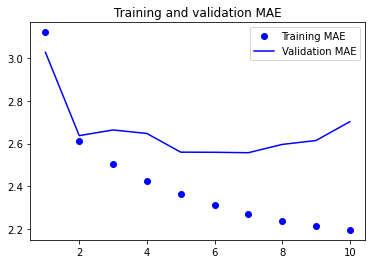

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Let's try a 1D convolutional model

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 51ms/step - loss: 21.2361 - mae: 3.6032 - val_loss: 19.8154 - val_mae: 3.5451
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 15.0942 - mae: 3.0855 - val_loss: 14.1206 - val_mae: 2.9559
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 13.6960 - mae: 2.9361 - val_loss: 14.8760 - val_mae: 3.0526
Epoch 4/10
819/819 [==============================] - 41s 49ms/step - loss: 12.8286 - mae: 2.8320 - val_loss: 14.8415 - val_mae: 3.0468
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 12.1948 - mae: 2.7561 - val_loss: 15.9991 - val_mae: 3.1499
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 11.6657 - mae: 2.6935 - val_loss: 15.3502 - val_mae: 3.0995
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 11.2903 - mae: 2.6487 - val_loss: 14.4573 - val_mae: 2.9906
Epoch 8/10
819/819 [============================

# A first recurrent baseline

### A simple LSTM-based model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 59ms/step - loss: 41.6179 - mae: 4.7157 - val_loss: 12.5188 - val_mae: 2.6843
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 10.9340 - mae: 2.5637 - val_loss: 9.4807 - val_mae: 2.3926
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.5581 - mae: 2.4018 - val_loss: 9.7824 - val_mae: 2.4275
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.1691 - mae: 2.3439 - val_loss: 10.0633 - val_mae: 2.4668
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 8.9497 - mae: 2.3128 - val_loss: 10.1204 - val_mae: 2.4709
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 8.8011 - mae: 2.2935 - val_loss: 10.1558 - val_mae: 2.4583
Epoch 7/10
819/819 [==============================] - 46s 55ms/step - loss: 8.6730 - mae: 2.2771 - val_loss: 9.7047 - val_mae: 2.4249
Epoch 8/10
819/819 [==============================] - 45

# Understanding recurrent neural networks

### NumPy implementation of a simple RNN

In [18]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_ouputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_ouputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_ouputs, axis=0)

# A recurrent layer in Keras

### An RNN layer that can process sequences of any length

In [24]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
print(outputs.shape)

(None, 16)


### An RNN layer that returns only its last output step

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


### An RNN layer that returns its full output sequence

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


### Stacking RNN layers

In [22]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
print(outputs.shape)

# Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

### Training and evaluating a dropout-regularized LSTM

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 357s 434ms/step - loss: 25.9051 - mae: 3.7701 - val_loss: 9.6554 - val_mae: 2.4079
Epoch 2/50
819/819 [==============================] - 342s 417ms/step - loss: 14.6557 - mae: 2.9743 - val_loss: 9.3723 - val_mae: 2.3686
Epoch 3/50
819/819 [==============================] - 341s 417ms/step - loss: 13.8324 - mae: 2.8860 - val_loss: 9.3250 - val_mae: 2.3646
Epoch 4/50
819/819 [==============================] - 344s 419ms/step - loss: 13.1980 - mae: 2.8215 - val_loss: 9.2115 - val_mae: 2.3437
Epoch 5/50
819/819 [==============================] - 341s 416ms/step - loss: 12.7766 - mae: 2.7787 - val_loss: 9.3262 - val_mae: 2.3608
Epoch 6/50
819/819 [==============================] - 342s 417ms/step - loss: 12.4482 - mae: 2.7379 - val_loss: 9.4036 - val_mae: 2.3652
Epoch 7/50
819/819 [==============================] - 337s 412ms/step - loss: 12.0091 - mae: 2.6881 - val_loss: 9.3875 - val_mae: 2.3605
Epoch 8/50
 27/819 [.....................

KeyboardInterrupt: ignored

In [26]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

# Stacking recurrent layers

### Training and evaluating a dropout-regularized, stacked GRU model

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 640s 776ms/step - loss: 21.6380 - mae: 3.3484 - val_loss: 8.9659 - val_mae: 2.3190
Epoch 2/50
157/819 [====>.........................] - ETA: 8:00 - loss: 9.8867 - mae: 2.4498

KeyboardInterrupt: ignored

# Using bidirectional RNNs

### Training and evaluating a bidirectional LSTM

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 50s 57ms/step - loss: 29.5449 - mae: 3.9632 - val_loss: 11.3954 - val_mae: 2.6244
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 9.9107 - mae: 2.4569 - val_loss: 9.9010 - val_mae: 2.4314
Epoch 3/10
819/819 [==============================] - 47s 58ms/step - loss: 8.7203 - mae: 2.3020 - val_loss: 9.8699 - val_mae: 2.4239
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 8.1789 - mae: 2.2251 - val_loss: 9.8906 - val_mae: 2.4311
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 7.7480 - mae: 2.1658 - val_loss: 9.8784 - val_mae: 2.4302
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 7.4657 - mae: 2.1299 - val_loss: 9.9172 - val_mae: 2.4362
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 7.1867 - mae: 2.0906 - val_loss: 10.7753 - val_mae: 2.5423
Epoch 8/10
819/819 [==============================] - 47s 5